In [1]:
import nltk
import numpy as np
import os
import pandas as pd

import fasttext
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import umap

plt.rcParams['font.size'] = 11
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = 'Arial'

/Users/alielassche/opt/anaconda3/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/alielassche/opt/anaconda3/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/alielassche/opt/anaconda3/lib/python3.9/site-packages/umap/distances.

## Source analysis

In [6]:
test_df = pd.read_csv('../output/clustered_sources_del_2023.csv', index_col=0, sep=';')
test_df.shape

(6155, 9)

In [7]:
test_df.columns

Index(['nr', 'file', 'year', 'page', 'source', 'context', 'cluster', 'nz',
       'loc'],
      dtype='object')

In [8]:
test_df['file_author'] = test_df['file'].str[:13]

In [9]:
test_df.groupby('loc')['loc'].count()

loc
c    4181
p    1974
Name: loc, dtype: int64

In [10]:
clusters_files = test_df.groupby(['file', 'year', 'cluster'])['cluster'].count()
clusters_files = clusters_files.unstack().reset_index().fillna(0)
clusters_files['cut'] = pd.cut(clusters_files['year'], np.arange(1550, 1950, 50))
clusters_files['cut'] = clusters_files['cut'].astype(str)
clusters_files['cut'] = clusters_files['cut'].replace(['(1850, 1900]', '(1800, 1850]'], '(1800, 1856]')
clusters_files.groupby('cut')[1, 2, 3, 4, 5, 6, 7, 8, 9].sum()


/var/folders/h3/_6gy9k2x3tgbm9pj_grj43rr0000gn/T/ipykernel_89629/2167864625.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  clusters_files.groupby('cut')[1, 2, 3, 4, 5, 6, 7, 8, 9].sum()


cluster,1,2,3,4,5,6,7,8,9
cut,,,,,,,,,
"(1550, 1600]",78.0,42.0,0.0,17.0,55.0,199.0,22.0,5.0,4.0
"(1600, 1650]",16.0,0.0,0.0,1.0,3.0,11.0,0.0,3.0,0.0
"(1650, 1700]",324.0,510.0,11.0,86.0,48.0,435.0,165.0,90.0,30.0
"(1700, 1750]",239.0,73.0,33.0,61.0,57.0,330.0,33.0,29.0,55.0
"(1750, 1800]",490.0,73.0,110.0,104.0,36.0,199.0,38.0,377.0,67.0
"(1800, 1856]",600.0,223.0,127.0,86.0,69.0,244.0,121.0,87.0,39.0


In [11]:
sources_clpl = pd.read_csv('../output/sources_clpl/sources_clpl_2022_del.csv', sep=';', index_col=0)
sources_clpl['cut'] = pd.cut(sources_clpl['year'], np.arange(1550, 1950, 50))
sources_clpl['cut'] = sources_clpl['cut'].astype(str)
sources_clpl['cut'] = sources_clpl['cut'].replace(['(1850, 1900]', '(1800, 1850]'], '(1800, 1856]')
sources_clpl.head()

,Batch,doc,doc_author,contemporain,page_start,scans,scans-annotated,Subcorpus,tokens_total,source,receiver,perception,written,heard,seen,else,year,cut
10,DBNL,1558_Bosc_Cupe,1558_Bosc_Cupe,n,55,228.0,228.0,1.0,61445,33,6,4,0,3,1,0,1558,"(1550, 1600]"
15,DBNL,1568_Gent_Vaer,1568_Gent_Vaer,y,1,223.0,58.0,0.0,128230,91,15,71,8,54,8,1,1568,"(1550, 1600]"
19,DBNL,1574_Antw_EykP,1574_Antw_EykP,n,43,125.0,125.0,1.0,50834,11,13,15,0,11,4,0,1574,"(1550, 1600]"
20,DBNL,1574_Antw_Haec,1574_Antw_Haec,y,1,357.0,147.0,0.0,115893,67,24,43,4,34,5,0,1574,"(1550, 1600]"
21,DBNL,1575_Antw_Ulle,1575_Antw_Ulle,n,37,131.0,130.0,1.0,60285,5,10,11,1,8,2,0,1575,"(1550, 1600]"


In [12]:
sources_tokens = pd.merge(clusters_files,sources_clpl[['doc', 'doc_author', 'tokens_total']], left_on='file', right_on='doc', how='left').drop(columns='doc')
sources_tokens.head()

,file,year,1,2,3,4,5,6,7,8,9,cut,doc_author,tokens_total
0,1558_Bosc_Cupe,1558,13.0,7.0,0.0,8.0,0.0,3.0,0.0,2.0,0.0,"(1550, 1600]",1558_Bosc_Cupe,61445.0
1,1568_Gent_Vaer,1568,13.0,1.0,0.0,5.0,15.0,53.0,4.0,0.0,0.0,"(1550, 1600]",1568_Gent_Vaer,128230.0
2,1574_Antw_EykP,1574,5.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,"(1550, 1600]",1574_Antw_EykP,50834.0
3,1574_Antw_Haec,1574,17.0,8.0,0.0,3.0,8.0,21.0,8.0,1.0,1.0,"(1550, 1600]",1574_Antw_Haec,115893.0
4,1575_Antw_Ulle,1575,1.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,"(1550, 1600]",1575_Antw_Ulle,60285.0


### Merge multiple volumes

In [13]:
sources_tokens = sources_tokens.groupby(['doc_author', 'year', 'cut'])['tokens_total', 1, 2, 3, 4, 5, 6, 7, 8, 9].sum().reset_index()

/var/folders/h3/_6gy9k2x3tgbm9pj_grj43rr0000gn/T/ipykernel_89629/562317276.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  sources_tokens = sources_tokens.groupby(['doc_author', 'year', 'cut'])['tokens_total', 1, 2, 3, 4, 5, 6, 7, 8, 9].sum().reset_index()


In [14]:
sources_tokens['1-norm'] = sources_tokens[1]/sources_tokens['tokens_total']
sources_tokens['2-norm'] = sources_tokens[2]/sources_tokens['tokens_total']
sources_tokens['3-norm'] = sources_tokens[3]/sources_tokens['tokens_total']
sources_tokens['4-norm'] = sources_tokens[4]/sources_tokens['tokens_total']
sources_tokens['5-norm'] = sources_tokens[5]/sources_tokens['tokens_total']
sources_tokens['6-norm'] = sources_tokens[6]/sources_tokens['tokens_total']
sources_tokens['7-norm'] = sources_tokens[7]/sources_tokens['tokens_total']
sources_tokens['8-norm'] = sources_tokens[8]/sources_tokens['tokens_total']
sources_tokens['9-norm'] = sources_tokens[9]/sources_tokens['tokens_total']

In [15]:
sources_tokens.to_csv('../output/sources_tokens_del.csv')

In [2]:
sources_tokens = pd.read_csv('../output/sources_tokens_del.csv', index_col=0, sep=';')
sources_tokens = sources_tokens.rename(columns = {'1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9})

### Find number source categories and coefficient variation in sources

In [3]:
new = sources_tokens.groupby('doc_author')[1, 2, 3, 4, 5, 6, 7, 8].sum()

# Define a normalization function
def normalize_row(row):
    row_sum = row.sum()
    normalized_row = row / row_sum
    return normalized_row

new2 = new.apply(normalize_row, axis=1)

/var/folders/h3/_6gy9k2x3tgbm9pj_grj43rr0000gn/T/ipykernel_40241/2973100166.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  new = sources_tokens.groupby('doc_author')[1, 2, 3, 4, 5, 6, 7, 8].sum()


In [4]:
cv = lambda x: np.std(x, ddof=1) / np.mean(x)

result_cv = pd.DataFrame(new.T.apply(cv).sort_values(ascending=True), columns=['cv']).reset_index()
result_cv['year'] = result_cv['doc_author'].str[:4]
result_cv['year'] = result_cv['year'].astype(int)
result_cv
result_cv.to_csv('../output/result_cv_sources.csv')

In [6]:
cat_sources = (new != 0).sum(axis=1)
cat_sources.to_csv('../output/cat_sources.csv')

In [7]:
cat_sources = pd.DataFrame(cat_sources, columns=['nr_sources']).reset_index()
cat_sources['year'] = cat_sources['doc_author'].str[:4]
cat_sources['year'] = cat_sources['year'].astype(int)

Text(0.5, 0, 'year')

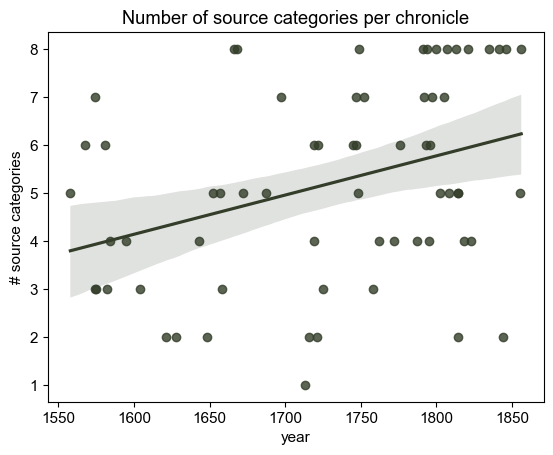

In [8]:
fig, axs = plt.subplots()

sns.regplot(x='year', y='nr_sources', data=cat_sources, marker='o', scatter_kws = {'color': '#333D29'}, line_kws = {'color': '#333D29'})
axs.set_title('Number of source categories per chronicle')
axs.set_ylabel('source categories')
axs.set_xlabel('year')

#fig.savefig('../images/cv_sources.pdf')

Text(0.5, 0, 'year')

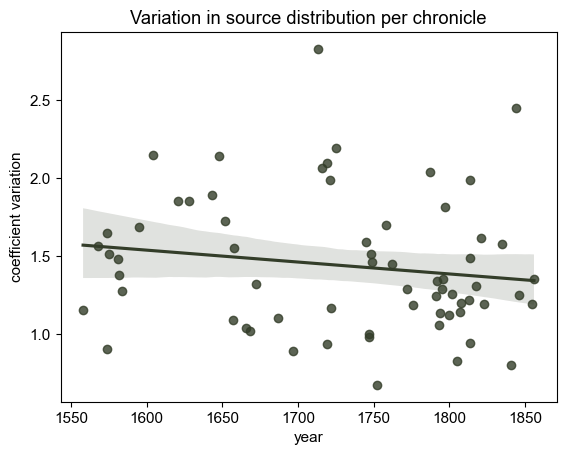

In [9]:
fig, axs = plt.subplots()

sns.regplot(x='year', y='cv', data=result_cv, marker='o', scatter_kws = {'color': '#333D29'}, line_kws = {'color': '#333D29'})
axs.set_title('Variation in source distribution per chronicle')
axs.set_ylabel('coefficient variation')
axs.set_xlabel('year')

#fig.savefig('../images/cv_sources.pdf')

In [5]:
sources_tokens.iat[38,14]=0.001

In [6]:
period = sources_tokens[sources_tokens['cut'] == '(1750, 1800]']
period[8]

34      2.0
35      0.0
36      1.0
37      0.0
38     19.0
39      1.0
40    243.0
41      1.0
42      0.0
43     92.0
44      1.0
45      1.0
46      0.0
47     16.0
Name: 8, dtype: float64

In [7]:
df_plot_norm = sources_tokens.melt(id_vars='cut', value_vars=['1-norm', '2-norm', '3-norm', '4-norm', '5-norm', '6-norm', '7-norm', '8-norm'])

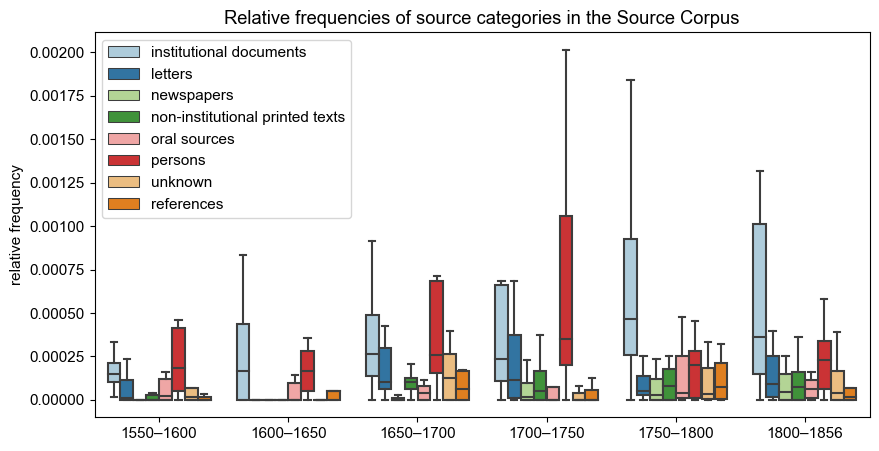

In [9]:
fig, axs = plt.subplots(figsize=(10,5))


sns.boxplot(x='cut', y='value', hue='variable', data=df_plot_norm, showfliers=False, palette='Paired')
axs.set_title('Relative frequencies of source categories in the Source Corpus')
axs.set_ylabel('relative frequency')
axs.xaxis.label.set_visible(False)
axs.set_xticklabels(['1550–1600', '1600–1650', '1650–1700', '1700–1750', '1750–1800', '1800–1856'], rotation=0)
#axs.set_ylim(0,0.005)

handles, labels = axs.get_legend_handles_labels()
labels = 'institutional documents', 'letters', 'newspapers', 'non-institutional printed texts', 'oral sources', 'persons', 'unknown', 'references'
axs.legend(handles, labels)

plt.savefig('../images/rel_freq_source_categories_fliers_del.pdf', bbox_inches='tight')

In [10]:
dfje = sources_tokens.groupby('cut')[[1, 2, 3, 4, 5, 6, 7, 8, 9]].sum().reset_index().drop(columns=['cut'])
dfje2 = dfje.drop(columns=[9])

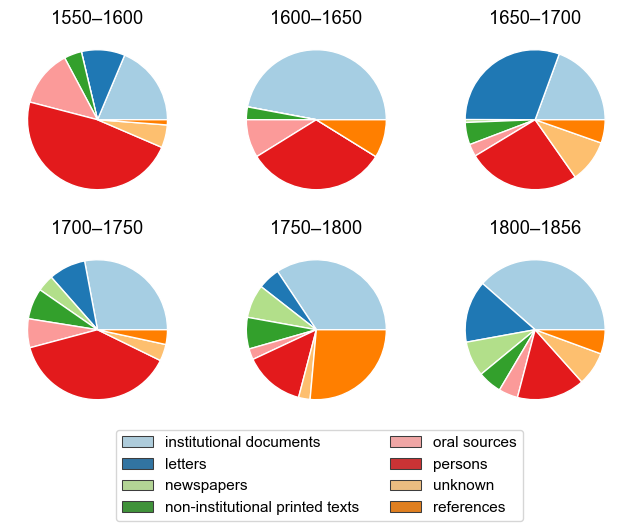

In [11]:
fig, (axes) = plt.subplots(2, 3, figsize=(8,5))
wedgeprops = { 'linewidth': 1, 'edgecolor' : 'white'}
palette_Paired = ["#A6CEE3", "#1F78B4", "#B2DF8A", "#33A02C", "#FB9A99", "#E31A1C", "#FDBF6F", "#FF7F00", "#CAB2D6", "#6A3D9A", "#FFFF99", "#B15928"]
palette2 = ['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#b15928']
 
#autopct = lambda p: '{:.1f}%'.format(p) if p > 0 else ''

ax1 = dfje2.iloc[0].plot.pie(ax = axes[0,0], wedgeprops=wedgeprops, colors=palette_Paired, labels=None)
ax1.set_title('1550–1600')
ax1.yaxis.label.set_visible(False)

ax2 = dfje2.iloc[1].plot.pie(ax = axes[0,1], wedgeprops=wedgeprops, colors=palette_Paired, labels=None)
ax2.set_title('1600–1650')
ax2.yaxis.label.set_visible(False)

ax3 = dfje2.iloc[2].plot.pie(ax = axes[0,2], wedgeprops=wedgeprops, colors=palette_Paired, labels=None)
ax3.set_title('1650–1700')
ax3.yaxis.label.set_visible(False)

ax4 = dfje2.iloc[3].plot.pie(ax = axes[1,0], wedgeprops=wedgeprops, colors=palette_Paired,labels=None)
ax4.set_title('1700–1750')
ax4.yaxis.label.set_visible(False)

ax5 = dfje2.iloc[4].plot.pie(ax = axes[1,1], wedgeprops=wedgeprops, colors=palette_Paired, labels=None)
ax5.set_title('1750–1800')
ax5.yaxis.label.set_visible(False)

ax6 = dfje2.iloc[5].plot.pie(ax = axes[1,2], wedgeprops=wedgeprops, colors=palette_Paired, labels=None)
ax6.set_title('1800–1856')
ax6.yaxis.label.set_visible(False)

labels = 'institutional documents', 'letters', 'newspapers', 'non-institutional printed texts', 'oral sources', 'persons', 'unknown', 'references'
fig.legend(handles, labels, bbox_to_anchor=(0.78,0.1), ncol=2)
#fig.suptitle('Relative frequencies per period of source categories in $Source$ $Corpus$')
plt.savefig('../images/piechart_sources.pdf', bbox_inches='tight')

In [12]:
sources_tokens = sources_tokens[sources_tokens['1-norm'] != 1]

/Users/alielassche/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


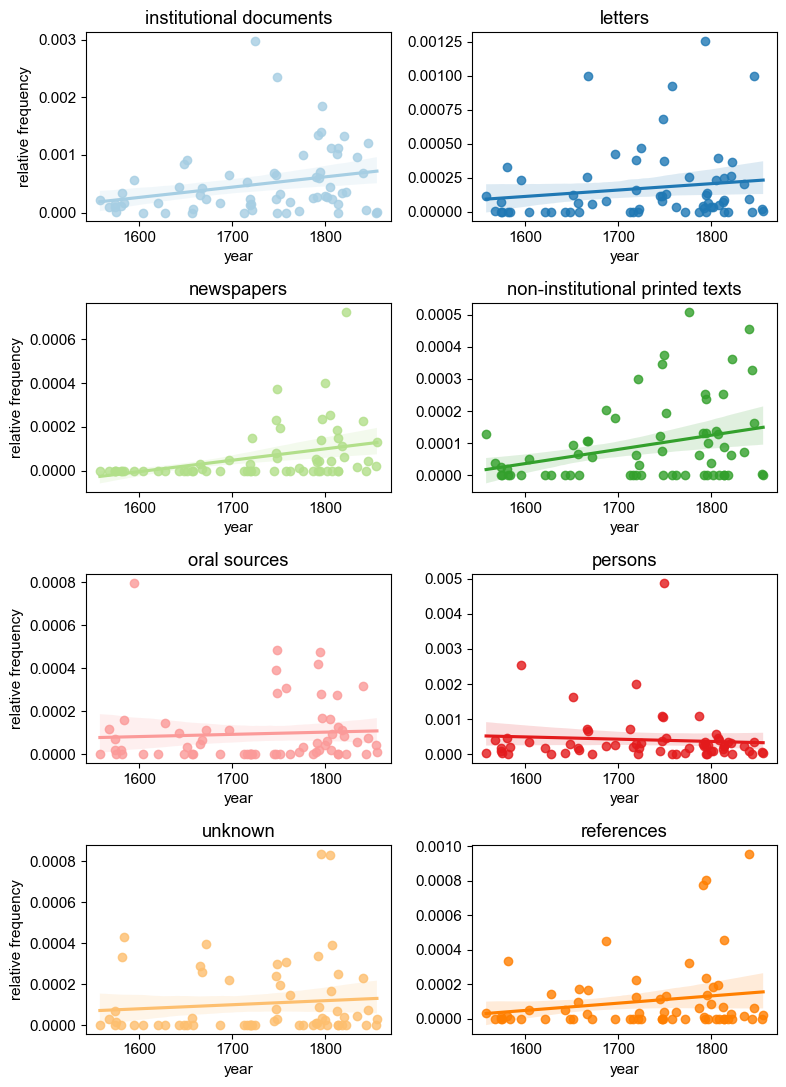

In [13]:
fig, ax = plt.subplots(4, 2, figsize=(8,11))
ax = ax.flatten()

#ax[0].set_ylim(0,0.003)
sns.regplot(x='year', y='1-norm', data=sources_tokens, color="#A6CEE3", ax=ax[0])
ax[0].set_title('institutional documents')
ax[0].set_ylabel('relative frequency')
ax[0].set_xlabel('year')

sns.regplot(x='year', y='2-norm', data=sources_tokens, color="#1F78B4", ax=ax[1])
ax[1].set_title('letters')
ax[1].set_ylabel('')
ax[1].set_xlabel('year')

sns.regplot(x='year', y='3-norm', data=sources_tokens, color="#B2DF8A", ax=ax[2])
ax[2].set_title('newspapers')
ax[2].set_ylabel('relative frequency')
ax[2].set_xlabel('year')

sns.regplot(x='year', y='4-norm', data=sources_tokens, color="#33A02C", ax=ax[3])
ax[3].set_title('non-institutional printed texts')
ax[3].set_ylabel('')
ax[3].set_xlabel('year')

sns.regplot(x='year', y='5-norm', data=sources_tokens, color="#FB9A99", ax=ax[4])
ax[4].set_title('oral sources')
ax[4].set_ylabel('relative frequency')
ax[4].set_xlabel('year')

sns.regplot(x='year', y='6-norm', data=sources_tokens, color="#E31A1C", ax=ax[5])
ax[5].set_title('persons')
ax[5].set_ylabel('')
ax[5].set_xlabel('year')

sns.regplot('year', y='7-norm', data=sources_tokens, color="#FDBF6F", ax=ax[6])
ax[6].set_title('unknown')
ax[6].set_ylabel('relative frequency')
ax[6].set_xlabel('year')

sns.regplot(x='year', y='8-norm', data=sources_tokens, color="#FF7F00", ax=ax[7])
ax[7].set_title('references')
ax[7].set_ylabel('')
ax[7].set_xlabel('year')

plt.tight_layout()

#plt.show()
plt.savefig('../images/scatter-sources.pdf', bbox_inches = 'tight')

## North vs South

In [14]:
north = sources_tokens[sources_tokens['northsouth'] == 'n']
south = sources_tokens[sources_tokens['northsouth'] == 's']

In [15]:
north_norm = north.melt(id_vars='cut', value_vars=['1-norm', '2-norm', '3-norm', '4-norm', '5-norm', '6-norm', '7-norm'])
south_norm = south.melt(id_vars='cut', value_vars=['1-norm', '2-norm', '3-norm', '4-norm', '5-norm', '6-norm', '7-norm'])

In [16]:
north_abs = north.groupby('cut')[[1, 2, 3, 4, 5, 6, 7, 8, 9]].sum().reset_index().drop(columns=['cut'])
north_abs_2 = north_abs.drop(columns=[8,9])

south_abs = south.groupby('cut')[[1, 2, 3, 4, 5, 6, 7, 8, 9]].sum().reset_index().drop(columns=['cut'])
south_abs_2 = south_abs.drop(columns=[8,9])


In [17]:
sources_tokens.head()

,doc_author,northsouth,year,cut,tokens_total,1,2,3,4,5,...,9,1-norm,2-norm,3-norm,4-norm,5-norm,6-norm,7-norm,8-norm,9-norm
0,1558_Bosc_Cupe,n,1558,"(1550, 1600]",61445.0,13.0,7.0,0.0,8.0,0.0,...,0.0,0.000212,0.000114,0.0,0.000130,0.000000,0.000049,0.000000,0.000033,0.000000
1,1568_Gent_Vaer,s,1568,"(1550, 1600]",128230.0,13.0,1.0,0.0,5.0,15.0,...,0.0,0.000101,0.000008,0.0,0.000039,0.000117,0.000413,0.000031,0.000000,0.000000
2,1574_Antw_EykP,s,1574,"(1550, 1600]",50834.0,5.0,0.0,0.0,0.0,1.0,...,0.0,0.000098,0.000000,0.0,0.000000,0.000020,0.000098,0.000000,0.000000,0.000000
3,1574_Antw_Haec,s,1574,"(1550, 1600]",115893.0,17.0,8.0,0.0,3.0,8.0,...,1.0,0.000147,0.000069,0.0,0.000026,0.000069,0.000181,0.000069,0.000009,0.000009
4,1575_Antw_Ulle,s,1575,"(1550, 1600]",60285.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.000017,0.000000,0.0,0.000000,0.000000,0.000033,0.000017,0.000000,0.000017


In [17]:
sources_tokens.groupby('northsouth')['tokens_total'].sum()

northsouth
n    2270256.0
s    1842163.0
Name: tokens_total, dtype: float64

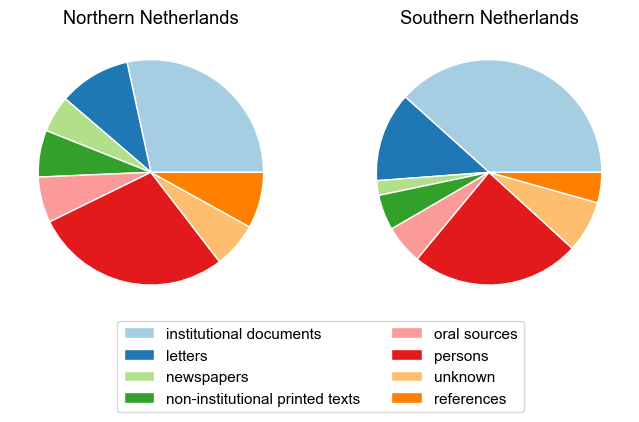

In [20]:
ns = sources_tokens.groupby('northsouth')[[1, 2, 3, 4, 5, 6, 7, 8]].sum().reset_index().drop(columns='northsouth')
ns_rel = sources_tokens.groupby('northsouth')[['1-norm', '2-norm', '3-norm', '4-norm', '5-norm', '6-norm', '7-norm', '8-norm']].sum().reset_index().drop(columns='northsouth')

fig, (axes) = plt.subplots(1, 2, figsize=(8,4))
wedgeprops = { 'linewidth': 1, 'edgecolor' : 'white'}
palette_Paired = ["#A6CEE3", "#1F78B4", "#B2DF8A", "#33A02C", "#FB9A99", "#E31A1C", "#FDBF6F", "#FF7F00", "#CAB2D6", "#6A3D9A", "#FFFF99", "#B15928"]
 
#autopct = lambda p: '{:.1f}%'.format(p) if p > 0 else ''

ax1 = ns_rel.iloc[0].plot.pie(ax = axes[0], wedgeprops=wedgeprops, colors=palette_Paired, labels=None)
ax1.set_title('Northern Netherlands')
ax1.yaxis.label.set_visible(False)

ax2 = ns_rel.iloc[1].plot.pie(ax = axes[1], wedgeprops=wedgeprops, colors=palette_Paired, labels=None)
ax2.set_title('Southern Netherlands')
ax2.yaxis.label.set_visible(False)

labels = 'institutional documents', 'letters', 'newspapers', 'non-institutional printed texts', 'oral sources', 'persons', 'unknown', 'references'
plt.legend(labels, bbox_to_anchor=(0.65,0), ncol=2)

#fig.suptitle('Relative frequencies of source categories in $Source$ $Corpus$')
plt.savefig('../images/piechart_northsouth.pdf', bbox_inches='tight')

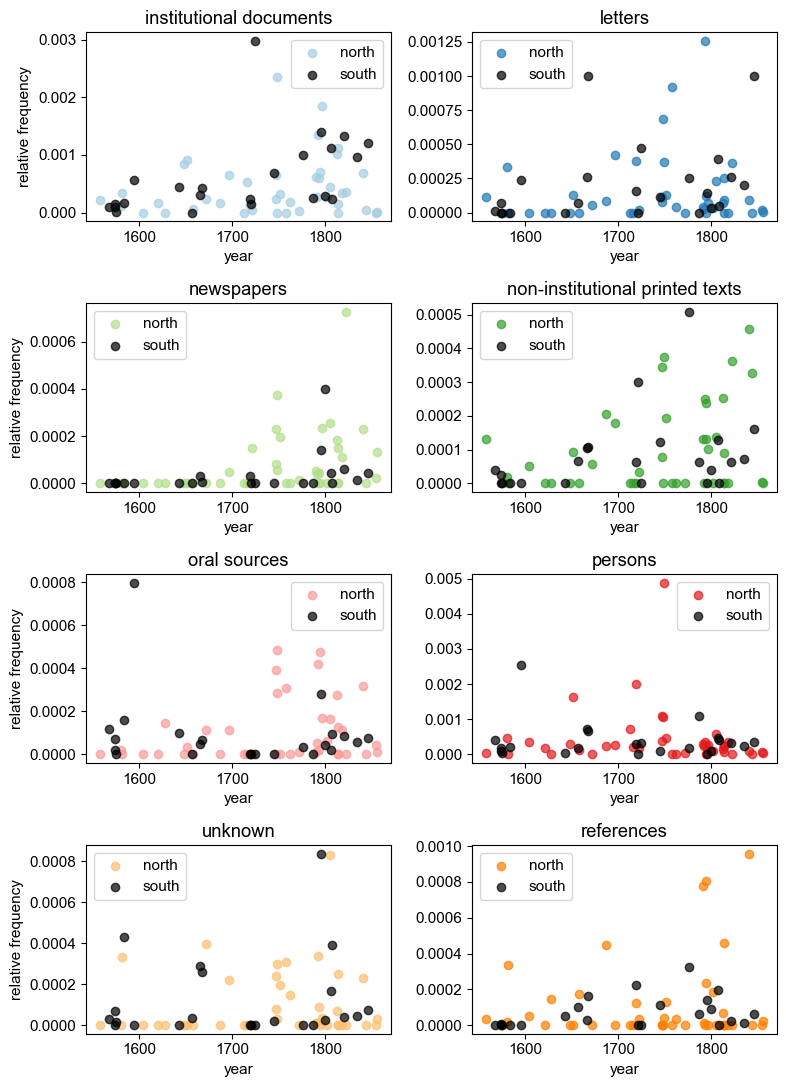

In [21]:
fig, axs = plt.subplots(4, 2, figsize=(8,11))
axs = axs.flatten()


colors = {'n':"#A6CEE3", 's': "#000000"}

groups = sources_tokens.groupby('northsouth')
for name, group in groups:
    colors = {'n':"#A6CEE3", 's': "#000000"}
    axs[0].scatter(group['year'], group['1-norm'], color=colors[name], alpha=0.7)
    axs[0].set_title('institutional documents')
    axs[0].set_ylabel('relative frequency')
    axs[0].set_xlabel('year')
    axs[0].legend(['north', 'south'])

for name, group in groups:
    colors = {'n': "#1F78B4", 's': "#000000"}
    axs[1].scatter(group['year'], group['2-norm'], color=colors[name], alpha=0.7)
    axs[1].set_title('letters')
    axs[1].set_ylabel('')
    axs[1].set_xlabel('year')
    axs[1].legend(['north', 'south'])

for name, group in groups:
    colors = {'n': "#B2DF8A", 's': "#000000"}
    axs[2].scatter(group['year'], group['3-norm'], color=colors[name], alpha=0.7)
    axs[2].set_title('newspapers')
    axs[2].set_ylabel('relative frequency')
    axs[2].set_xlabel('year')
    axs[2].legend(['north', 'south'])

for name, group in groups:
    colors = {'n': "#33A02C", 's': "#000000"}
    axs[3].scatter(group['year'], group['4-norm'], color=colors[name], alpha=0.7)
    axs[3].set_title('non-institutional printed texts')
    axs[3].set_ylabel('')
    axs[3].set_xlabel('year')
    axs[3].legend(['north', 'south'])

for name, group in groups:
    colors = {'n': "#FB9A99", 's': "#000000"}
    axs[4].scatter(group['year'], group['5-norm'], color=colors[name], alpha=0.7)
    axs[4].set_title('oral sources')
    axs[4].set_ylabel('relative frequency')
    axs[4].set_xlabel('year')
    axs[4].legend(['north', 'south'])

for name, group in groups:
    colors = {'n': "#E31A1C", 's': "#000000"}
    axs[5].scatter(group['year'], group['6-norm'], color=colors[name], alpha=0.7)
    axs[5].set_title('persons')
    axs[5].set_ylabel('')
    axs[5].set_xlabel('year')
    axs[5].legend(['north', 'south'])

for name, group in groups:
    colors = {'n': "#FDBF6F", 's': "#000000"}
    axs[6].scatter(group['year'], group['7-norm'], color=colors[name], alpha=0.7)
    axs[6].set_title('unknown')
    axs[6].set_ylabel('relative frequency')
    axs[6].set_xlabel('year')
    axs[6].legend(['north', 'south'])

for name, group in groups:
    colors = {'n': "#FF7F00", 's': "#000000"}
    axs[7].scatter(group['year'], group['8-norm'], color=colors[name], alpha=0.7)
    axs[7].set_title('references')
    axs[7].set_ylabel('')
    axs[7].set_xlabel('year')
    axs[7].legend(['north', 'south'])

plt.tight_layout()
#plt.show()
#plt.savefig('../images/scatter-sources-north-south.pdf', bbox_inches = 'tight')

### Count tokens

In [20]:
path = glob.glob(os.path.join('../test/*.txt'))
all_rows = []
d_line = dict()

for file in path:
    print(file)
    num_words = 0
    text = open(file, 'rt', encoding='utf-8').read()
    words = text.strip().lower().split()
    num_words += len(words)
    print(num_words)

../test/1786_Oude_Rant.txt
35618
../test/1814_Worm_Ding.txt
8673
../test/1650_Boei_Boei.txt
7
../test/1668_Gent_Bill_11.txt
68636
../test/1668_Gent_Bill_10.txt
69747


### Count sources in chronicle

In [12]:
dirksen = test_df[test_df['file'] == '1668_Gent_Bill_12']
dirksen.groupby('cluster')['cluster'].count()

cluster
1     44
2    294
3      2
4      1
5     12
6     81
7     57
Name: cluster, dtype: int64

In [11]:
sources_tokens[sources_tokens['doc_author'] == '1668_Gent_Bill']

,doc_author,northsouth,year,cut,tokens_total,1,2,3,4,5,...,9,1-norm,2-norm,3-norm,4-norm,5-norm,6-norm,7-norm,8-norm,9-norm
18,1668_Gent_Bill,s,1668,"(1650, 1700]",431584.0,187.0,432.0,3.0,46.0,28.0,...,1.0,0.000433,0.001001,0.000007,0.000107,0.000065,0.000672,0.000257,0.000165,0.000002


In [11]:
persons = test_df[test_df['cluster'] == 6]
persons.shape

(1699, 7)

In [16]:
substr = ['seg', 'hoor', 'spreek', 'zeg', 'horen', 'sei', 'zei', 'antwoord', 'vertel', 'sprak', 'verhaal', 'roep', 'riep', 'zey', 'sey', 'verklaar', 'verclaar', 'verklar', 'verclaer', 'verclar']
persons.loc[persons['context'].str.contains('|'.join(substr))]

,nr,file,year,page,source,context,cluster
3957,3315,1787_Gent_Anon_01,1787,22.0,en prins,d en prins seyde en hebbe ick,6
3959,5864,1748_Berg_Folk,1748,78.0,155 maagt,155 maagt mij roepen zeijd dat er twee heeren...,6
3967,354,1749_Rott_Sche,1749,9.0,9 wyven,Dit gezegd zynde zag ik omkykende 9 wyven han...,6
3968,999,1668_Gent_Bill_05,1668,62.0,a ick,Schepenen ende polliciemeesters & a Ick seide...,6
3971,3829,1668_Gent_Bill_02,1668,105.0,aermen man,heeren voor Antwoorde dat desen aermen man mij...,6
...,...,...,...,...,...,...,...
5648,5862,1748_Berg_Folk,1748,78.0,zy,verhaalde zy mij dat zij corsen waren üijt t ...,6
5649,4814,1754_Izeg_Tang,1754,74.0,zy,Ter plaetsen zeggen zy alwaer tot alsnu geene ...,6
5651,5524,1776_Mech_Nieu_02,1776,37.0,zy,op welke antwoord zy hebben gezeyd wy willen ...,6
5652,550,1749_Rott_Sche,1749,38.0,zyn e,hy gedimuteerd was waarop Zyn E zeide dat de ...,6


## Label full corpus based on rules

In [18]:
path = glob.glob(os.path.join('../corpus/corpus_220915/*.txt'))
all_rows = []
d_line = dict()

for file in path:
    
    text = open(file, 'rt', encoding='utf-8').read()
    wordlist = text.strip().lower().split()
    
    with open(file, 'rt', encoding='utf-8') as doc:
        lines = doc.readlines()
        for line in lines:
            words = line.strip().lower().split()
            for word in words:
                word = remove_punct(word)
                d_line['file'] = re.search(r"(?<=915/)(.*?)(?=.txt)", file).group(0)
                d_line['year'] = d_line['file'][:4]
                d_line['source'] = word
                d_line['context'] = context_window(line, word)
                d_line['n-tokens'] = len(wordlist)
                if word in (courant + gazette + advertentie):
                    d_line['cluster'] = 1
                    all_rows.append(d_line)
                    d_line = dict()
                elif word in (brief + depeche):
                    d_line['cluster'] = 2
                    all_rows.append(d_line)
                    d_line = dict()
                elif word in (edict + plakkaat + decreet + ordonnantie + verzoek + contract + request + gebod + copie + octrooij + gebod + publicatie):
                    d_line['cluster'] = 3
                    all_rows.append(d_line)
                    d_line = dict()
                elif word in (tijding + gerucht + rumoer + mare + proclamatie):
                    d_line['cluster'] = 4
                    all_rows.append(d_line)
                    d_line = dict()
                elif word in bericht:
                    d_line['cluster'] = 5
                    all_rows.append(d_line)
                    d_line = dict()
                elif word in (boek + aantekeningen):
                    d_line['cluster'] = 8
                    all_rows.append(d_line)
                    d_line = dict()    
                else:
                    continue

full_corpus = pd.DataFrame(all_rows)
full_corpus['year'] = full_corpus['year'].astype('int')

In [46]:
full_corpus.to_csv('../output/full_corpus.csv')

In [3]:
full_corpus = pd.read_csv('../output/clustered_sources_new_numbers.csv', sep=';', index_col=0)
full_corpus.head()

,nr,file,year,page,source,context,cluster
0,4469,1791_Purm_Louw,1791,432.0,8 junij heden hadden wij alhier wegens het gen...,8 Junij heden hadden Wij alhier wegens het Gen...,3
1,4590,1791_Purm_Louw,1791,582.0,aangeplakte advertentie,geroepen bij eene Aangeplakte Advertentie dat ...,3
2,4399,1791_Purm_Louw,1791,321.0,advertens,In de advertens onder Purmerende 19 Septemb 1776,3
3,4394,1791_Purm_Louw,1791,320.0,advertensiën,Advertensiën,3
4,4397,1791_Purm_Louw,1791,320.0,advertensiën haerlemm courant in dato 19 septe...,Advertensiën Haerlemm Courant in dato 19 Septe...,3


In [4]:
cluster8 = full_corpus[full_corpus['cluster'] == 8]
cluster8.head()

,nr,file,year,page,source,context,cluster
5654,1876,1753_Vlis_anon,1753,18.0,287,287,8
5655,3911,1800_Brug_Wall_06,1800,122.0,- fol 515 - versaemelinge n 3 onder de stukken...,- fol 515 - versaemelinge N 3 onder de stukken...,8
5656,5750,1846_Antw_Coni_03,1846,44.0,@@ folio 134 nota,en Grauwnonnen zyn gaen Woonen @@ folio 134 nota,8
5657,4381,1791_Purm_Louw,1791,274.0,# deze dijkbaas werd hier voor op bladz 369 ge...,# deze dijkbaas werd hier Voor op bladz 369 ge...,8
5658,4473,1791_Purm_Louw,1791,443.0,# zie hier van nader op bladz 318,# zie hier van nader op Bladz 318,8


In [5]:
cluster8.to_csv('../output/cluster8.csv')

In [19]:
full_corpus.groupby('cluster')['cluster'].count()

cluster
1     2615
2    10170
3    19402
4     8208
5     1785
8     3575
Name: cluster, dtype: int64

In [47]:
full_corpus.groupby('cluster')['cluster'].count()

cluster
1     2615
2     8934
3    20604
4     8208
5     1785
8     3526
Name: cluster, dtype: int64